# Flower Classification Using Clustering 
Clustering-based approach to classify things comes in unsupervising learning. In this reposisotry, we compare three important methods using for clustering or to perform similarity check. These are,
* Principle Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE)
* Uniform Manifold Approximation and Projection (UMAP)


In [1]:
# Copy into first cell
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Flower_Classification_Visualization/"

# Switch to uploaded folder
import os
os.chdir('gdrive/My Drive/Flower_Classification_Visualization/')

Mounted at /content/gdrive


In [2]:
!pip install -r requirements.txt;

In [0]:
# Load required packages

# from nbs.utils import *
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
import matplotlib.pyplot as plt

In [0]:
## Path to the directory, where the data is located

# path = Path('/Users/Pike/Google Drive/Flower_Classification_Visualization/data/flower_data_small')
# path

In [5]:
path = Path(root_dir+'/data/flower_data_small')
path

Path('/content/gdrive/My Drive/Flower_Classification_Visualization/data/flower_data_small')

In [0]:
# Make the path to the base one so that we can give the reference later in the notebook with respect to the data directory

Path.BASE_PATH = path

In [7]:
path.ls()

(#2) [Path('train'),Path('valid')]

In [0]:
# make a data loader

flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y= parent_label,
                item_tfms = Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=.75)
                )

batch_size  =32
dls = flowers.dataloaders(path, bs = batch_size,num_workers=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


torch.Size([32, 3, 224, 224])
torch.Size([32])


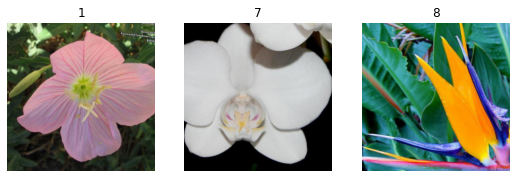

In [9]:
# Show images size 

imgs,labels = dls.one_batch()
print(imgs.shape)
print(labels.shape)

dls.show_batch(nrows=1,ncols =3)

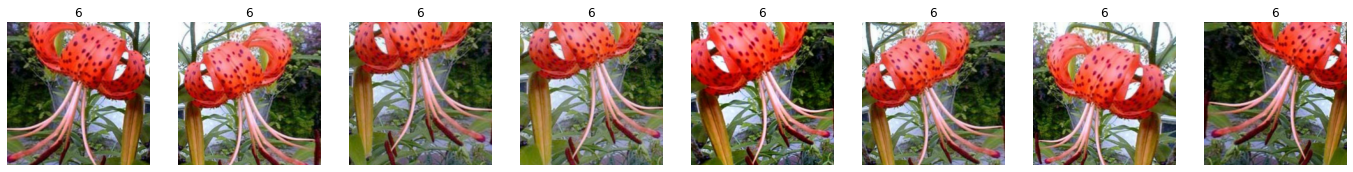

In [10]:
# As know, we perform data augumentation. Hence, we show four different augumented images of an image

dls.show_batch(nrows=1, ncols = 8, unique=True)

# Visulization of Row-Images 

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from pylab import *
import numpy as no
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [0]:
def plot_scatter(x_data,y_data,total_labels,title = ''):
    plt.figure(figsize=(6,6))
    cmap = cm.get_cmap('jet',10)
    plt.scatter(x=x_data,y=y_data,c=total_labels,s=35,cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Using PCA

In [14]:

pca = PCA(n_components=2)
pca.fit(imgs.reshape(batch_size,-1).to('cpu'))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
total_images = np.array([]).reshape(0,3*224*224)
total_labels = np.array([])
i = 0
for imgs,labels in next(iter(dls)):
    total_images = np.concatenate((total_images, (imgs.reshape((len(imgs),3*224*224))).to('cpu').numpy()))
    total_labels = np.concatenate((total_labels,labels.to('cpu')))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
total_pca_feature = np.array([]).reshape(0,2)
total_pca_feature = np.concatenate((total_pca_feature, pca.transform(total_images)))

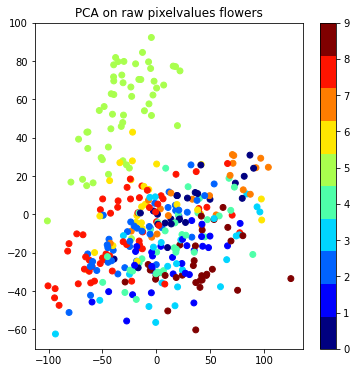

In [17]:
plot_scatter(total_pca_feature[:,0],total_pca_feature[:,1],total_labels,'PCA on raw pixelvalues flowers')

### Using T-SNE

In [0]:
model = TSNE(n_components=2,random_state=0)
tsne = model.fit_transform(total_images.reshape(len(total_images),-1))

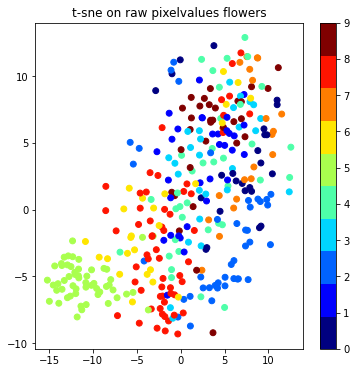

In [19]:
plot_scatter(tsne[:,0],tsne[:,1],total_labels,'t-sne on raw pixelvalues flowers')

### Using UMAP

In [0]:
# %%timeit
reducer = umap.UMAP(random_state=42)
umap_data = reducer.fit_transform(total_images)

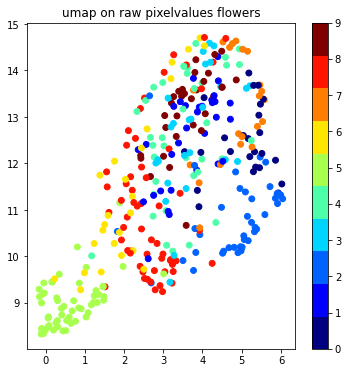

In [21]:
plot_scatter(umap_data[:,0],umap_data[:,1],total_labels,'umap on raw pixelvalues flowers')

# Visualization of images based on VGG16
As we know, low-dimensional projection of the images using raw-data does not perform well. Hence, we use VGG16 network to get features of images at a particular layer and then apply PCA, t-sne, and umap.

In [0]:
# We load vgg16_bn model that is pretained.

learn = cnn_learner(dls,vgg16_bn, pretrained=True, metrics=error_rate)
# learn.summary()

In [0]:
# We extract the output at the last batch-normalization layer in the model. Have a look at the summary to get an idea.

learn.model[1] = nn.Sequential(
    learn.model[1][:6]
)
# learn.summary()

In [24]:
# To get the output at the last ReLU layer for a given input image. The size of the output should be (batch_size x 512).

hidden_output = learn.model(imgs)

hidden_output.shape

torch.Size([32, 512])

#### Determine low-dimensional features of image using dataloader. There are some adavantages of using dataloader type framework:
* It does data augumentation; hence, clustering is more robust with respect to the variance in the data
* It can make use of GPUs properly

In [25]:

total_hidden_feature = np.array([]).reshape(0,512)
total_labels = np.array([])
i = 0
for imgs,labels in next(iter(dls)):
    total_hidden_feature = np.concatenate((total_hidden_feature, learn.model(imgs).detach().to('cpu').numpy()))
    total_labels = np.concatenate((total_labels,labels.to('cpu')))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [26]:
total_hidden_feature.shape

(352, 512)

### Using PCA

In [27]:
pca = PCA(n_components=2)
pca.fit(total_hidden_feature)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
%time pca_feature_vgg = pca.transform(total_hidden_feature)

CPU times: user 1.1 ms, sys: 1.94 ms, total: 3.04 ms
Wall time: 2.91 ms


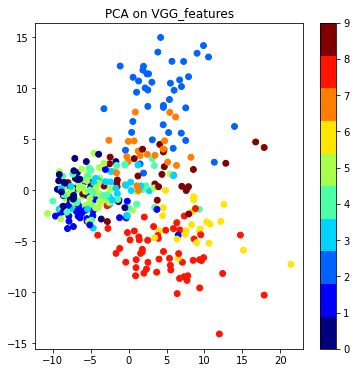

In [29]:
plot_scatter(pca_feature_vgg[:,0],pca_feature_vgg[:,1],total_labels,'PCA on VGG_features')

### Using t-sne

In [30]:
model = TSNE(n_components=2)
%time tsne_vgg = model.fit_transform(total_hidden_feature)

CPU times: user 2.57 s, sys: 10.3 ms, total: 2.58 s
Wall time: 2.59 s


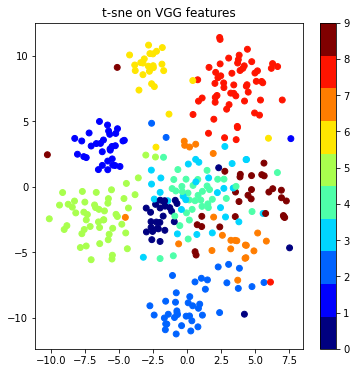

In [31]:
plot_scatter(tsne_vgg[:,0],tsne_vgg[:,1],total_labels,'t-sne on VGG features')

### Using UMAP

In [0]:
reducer = umap.UMAP(random_state=42)

CPU times: user 1.88 s, sys: 5.6 ms, total: 1.88 s
Wall time: 1.88 s


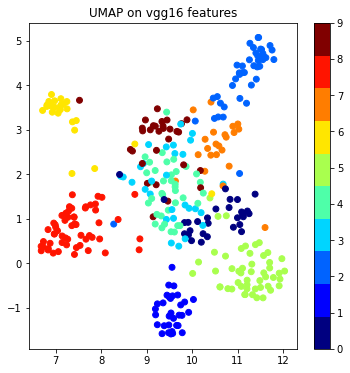

In [33]:
%time umap_data_vgg = reducer.fit_transform(total_hidden_feature)
plot_scatter(umap_data_vgg[:,0], umap_data_vgg[:,1], total_labels,'UMAP on vgg16 features')

In [34]:
# Let us augumentation using Epochs
total_hidden_feature_Epoch = np.array([]).reshape(0,512)
total_labels_Epoch = np.array([])
i = 0
numEpochs = 3
for epoch in range(numEpochs):
  for imgs,labels in next(iter(dls)):
      total_hidden_feature_Epoch = np.concatenate((total_hidden_feature_Epoch, learn.model(imgs).detach().to('cpu').numpy()))
      total_labels_Epoch = np.concatenate((total_labels_Epoch,labels.to('cpu')))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [35]:
total_hidden_feature_Epoch.shape,total_labels_Epoch.shape

((1056, 512), (1056,))

In [36]:
print(total_labels_Epoch)

[8. 8. 6. ... 2. 5. 5.]


In [37]:
pca = PCA(n_components=2)
pca.fit(total_hidden_feature_Epoch)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [38]:
%time pca_feature_vgg_Epoch = pca.transform(total_hidden_feature_Epoch)
pca_feature_vgg_Epoch

CPU times: user 5.04 ms, sys: 896 µs, total: 5.94 ms
Wall time: 5.62 ms


array([[-0.77342769, -5.79199802],
       [ 8.37052054, -6.96920137],
       [ 6.8926773 , -5.21127541],
       ...,
       [-4.49282629,  5.39260006],
       [-3.45493324,  1.16381098],
       [-3.92031173,  2.10686029]])

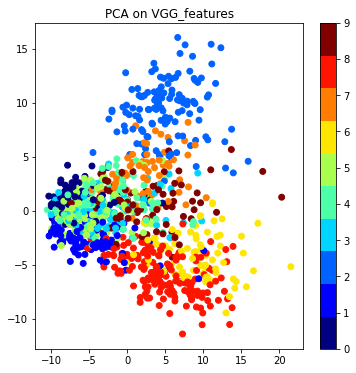

In [39]:
plot_scatter(pca_feature_vgg_Epoch[:,0],pca_feature_vgg_Epoch[:,1],total_labels_Epoch,'PCA on VGG_features')

### Using t-sne

In [40]:
model = TSNE(n_components=2)
%time tsne_vgg_Epoch = model.fit_transform(total_hidden_feature_Epoch)

CPU times: user 10.4 s, sys: 23.7 ms, total: 10.4 s
Wall time: 10.4 s


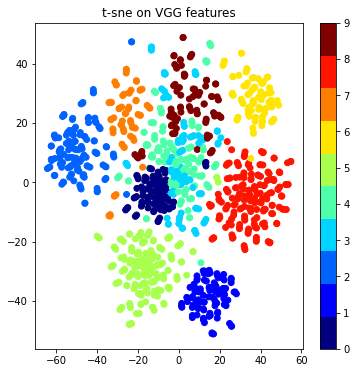

In [41]:
plot_scatter(tsne_vgg_Epoch[:,0],tsne_vgg_Epoch[:,1],total_labels_Epoch,'t-sne on VGG features')

### Using UMAP

In [0]:
reducer = umap.UMAP(random_state=42)

CPU times: user 4.26 s, sys: 108 ms, total: 4.37 s
Wall time: 4.22 s


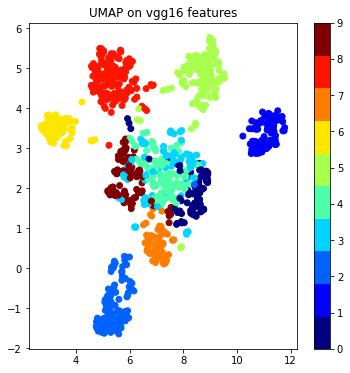

In [43]:

%time umap_data_vgg_Epoch = reducer.fit_transform(total_hidden_feature_Epoch)
plot_scatter(umap_data_vgg_Epoch[:,0], umap_data_vgg_Epoch[:,1], total_labels_Epoch,'UMAP on vgg16 features')